# Import and Prepare data

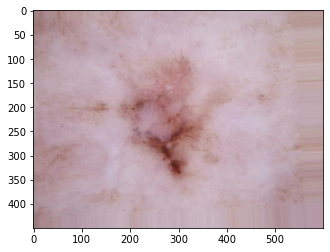

In [1]:
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


#get first data set images 
contents= os.listdir('E:/Projects/PFA/Data sets/data/HAM10000_images_part_2/')
img= Image.open(('E:/Projects/PFA/Data sets/data/HAM10000_images_part_2/' + contents[50]))
#[test]open image
plt.imshow(img)

In [2]:
import pandas as pd
from sklearn.utils import shuffle

"""
# Read the existing CSV file
dff = pd.read_csv('E:/Projects/PFA/Data sets/data/HAM10000_metadata - Copy.csv')

# List of unique values in the "dx" column
dx_values = dff['dx'].unique()

# Create an empty DataFrame to store the sampled data
df = pd.DataFrame()

# Iterate over each unique value and sample 30 lines from each
for dx_value in dx_values:
    # Filter the DataFrame for the current dx value
    filtered_data = dff[dff['dx'] == dx_value]
    
    # Sample 30 lines from the filtered data
    sampled_lines = filtered_data.sample(n=100)
    
    # Append the sampled lines to the sampled_data DataFrame
    df = df.append(sampled_lines)

# Save the sampled data to a new CSV file
df.to_csv('sampled_file.csv', index=False)
"""

#define our data fragment
df= pd.read_csv('E:/Projects/PFA/Data sets/data/HAM10000_metadata - Copy.csv', )

#print only disease type (classes that we will use)
print(df['dx'].unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


# Prepare data to be used with PyTorch

(450, 600, 3)


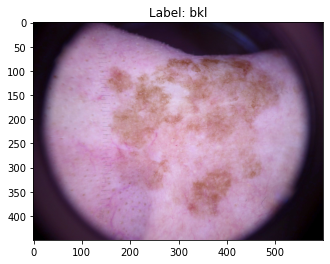

In [3]:
from torchvision.transforms import transforms, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from scipy import ndimage
import torch

# converting dataset into pytorch Dataset datastructure
#tranform df from row data taken from csv file into dataframe
class skinMNIST(Dataset):

#initialise dataset with data passed by parameter
  def __init__(self, dataframe, transforms= None):
    super().__init__()
    self.df= dataframe
    self.transform= transforms

#return dataset length
  def __len__(self):
    return(self.df.shape[0])

#extract labels and order them
  def labels(self):
    labels= self.df['dx'].unique()
    labels= sorted(labels)
    return 
    
# this method return number of images per label
  def description(self):
    return self.df['dx'].value_counts()

#returns a tuple of image tensor and label tensor for a given index idx
  def __getitem__(self, idx):
    labels= dict(zip(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], range(7)))
    
    #get data row by id : idx
    row = self.df.iloc[idx]
    
    #load image of returned row
    image = row['image_id'] 
    
    #maps the label names to integers
    label_one_hot= np.zeros(7).astype(int)
    label_one_hot[labels[row['dx']]] = 1
    
 
    try:
      image= Image.open(('E:/Projects/PFA/Data sets/data/ham10000_images_part_2/' + image + '.jpg'))
    except:
      image= Image.open(('E:/Projects/PFA/Data sets/data/ham10000_images_part_1/' + image + '.jpg'))

    if self.transform:
      image= self.transform(image)
#return encoded image & encoded label
    return image, torch.tensor(label_one_hot)

#visualizes an image with its label for a given index idx
  def visulizeitem(self, idx):
    row = self.df.iloc[idx]
    image = row['image_id']
    label = row['dx'] 
    try:
      image= Image.open(('E:/Projects/PFA/Data sets/data/ham10000_images_part_2/' + image + '.jpg'))
    except:
      image= Image.open(('E:/Projects/PFA/Data sets/data/ham10000_images_part_1/' + image + '.jpg'))

    #print height, width, and number of color channels of the image
    print(np.shape(image))
    fig= plt.figure()
    plt.title('Label: {}'.format(label))
    plt.imshow(image)
    
#This line defines a data transformation pipeline using the Compose method from torchvision.transforms.
#ToTensor() : converts the image data to PyTorch tensors
#Normalize() : normalizes the tensor values using the mean and standard deviation values provided as arguments.
#transfors.Compose() : used to combine the last two transformations.
tf= transforms.Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


#create instance of class skinMNIST 
ds= skinMNIST(df, tf)

#test visulizeitem method
ds.visulizeitem(20)

Row data nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64
Structured {'nv': 6705, 'mel': 1113, 'bkl': 1099, 'bcc': 514, 'akiec': 327, 'vasc': 142, 'df': 115}


<BarContainer object of 7 artists>

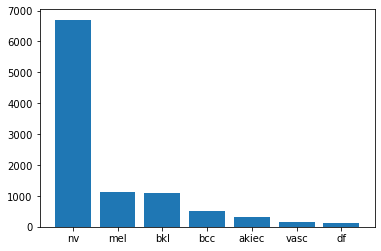

In [4]:
# test description method

desc= ds.description()
print("Row data",desc)

#transform row output to dictionary data structure so it can be readable
desc= dict(desc)
print("Structured",desc)

#display information class per number of images
plt.bar(desc.keys(), desc.values())

# partial data augmentation to balance dataset

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm_notebook as tqdm

#transform image by changing data auglentation parameters
gen= ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, 
                        shear_range=0.15, zoom_range= 0.1, channel_shift_range= 10, horizontal_flip= True)

main_dir = 'E:/Projects/PFA/Data sets/data/'

#go throw differnt desc element 
#reminder of the desc content: {'nv': 6705, 'mel': 1113, 'bkl': 1099, 'bcc': 514, 'akiec': 327, 'vasc': 142, 'df': 115}

for key in desc.keys():
    
    print('first class + original size',key, desc[key])
    
    #compare number of images in class 'nv' to current class inside loop 
    ratio= int(desc['nv']/ desc[key])
    print('ratio to nv: ', ratio)
    
    #augmentation refers to the process of artificially increasing the size of a dataset by creating modified versions of the existing data. 
    print('We need around', ratio,' augmentation per image to change ratio to 1')
    
    #selects all the image IDs from the DataFrame df where the dx column is equal to the current category 'key'
    all_images= df[df['dx'] == key]['image_id'].values
    
    #if current category is 'nv' skip treatment
    if(key == 'nv'):
        continue

    printonce= True
    
    # iterate over all images augment them, save them and insert them in our metadata frame
    for image_ in tqdm(all_images):
        
        #if number of images in this category is greater than 'nv' than stop augmentation 
        if(len(df[df['dx'] == key]) > len(df[df['dx'] == 'nv'])):
            if printonce:
                print(key, 'datapoints = ', len(df[df['dx'] == key]), 'reached above nv datapoints =', len(df[df['dx'] == 'nv']) ,' skipping more augmentations..')
                printonce= False
            continue
            
        try:
            basedir= main_dir+'ham10000_images_part_1/'
            image_path=  basedir + image_ + '.jpg'
            image= load_img(image_path)
        except:
            basedir= main_dir+'ham10000_images_part_2/'
            image_path= basedir + image_ + '.jpg'
            image= load_img(image_path)

        #generate augmented image dimention
        #the ImageDataGenerator expects a 4D array with an additional dimension for the batch size.
        #To add this extra dimension to our image numpy array, we use the np.expand_dims function with axis=0. 
        #This results in an array of shape (1, height, width, channels).
        image= np.expand_dims(img_to_array(image), axis= 0)
        
        #generate augmented images from the given input image based on the parameters we configured
        generated= gen.flow(image)
        
        #select image from old data frame of the to be augmented image 
        row= df[df['image_id'] == image_]
        
        #transfer row to dictionnary structured data
        dict_for_df= {
            'lesion_id':row.lesion_id.values[0], 
            'image_id':row.image_id.values[0], 
            'dx':row.dx.values[0], 
            'dx_type':row.dx_type.values[0] ,
            'age':row.age.values[0], 
            'sex':row.sex.values[0], 
            'localization':row.localization.values[0] 
        }
        
        #aumgment image 'ratio' times
        for i in range(int(ratio)):
          #This line generates an augmented image using the next()
          aug_image= next(generated).astype(np.uint8)
            
          # update image name according to it older version
          image_name= dict_for_df['image_id'] + '_' + str(i)
            
          # update the row image name with the new one so the next ration we will update it accoring to the previous update
          dict_for_df['image_id'] = image_name
            
          #add new image to existing dataframe
          df = df.append(dict_for_df, ignore_index=True)
            
          # write the updated data to the csv file
          #df.to_csv('E:/Projects/PFA/Data sets/data/HAM10000_metadata.csv', index=False)
            
          #save image to disk
          plt.imsave(basedir + image_name + '.jpg', aug_image[0])

first class + original size nv 6705
ratio to nv:  1
We need around 1  augmentation per image to change ratio to 1
first class + original size mel 1113
ratio to nv:  6
We need around 6  augmentation per image to change ratio to 1


<ipython-input-5-9194c3f59f45>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_ in tqdm(all_images):


  0%|          | 0/1113 [00:00<?, ?it/s]

mel datapoints =  6711 reached above nv datapoints = 6705  skipping more augmentations..
first class + original size bkl 1099
ratio to nv:  6
We need around 6  augmentation per image to change ratio to 1


  0%|          | 0/1099 [00:00<?, ?it/s]

bkl datapoints =  6709 reached above nv datapoints = 6705  skipping more augmentations..
first class + original size bcc 514
ratio to nv:  13
We need around 13  augmentation per image to change ratio to 1


  0%|          | 0/514 [00:00<?, ?it/s]

bcc datapoints =  6715 reached above nv datapoints = 6705  skipping more augmentations..
first class + original size akiec 327
ratio to nv:  20
We need around 20  augmentation per image to change ratio to 1


  0%|          | 0/327 [00:00<?, ?it/s]

akiec datapoints =  6707 reached above nv datapoints = 6705  skipping more augmentations..
first class + original size vasc 142
ratio to nv:  47
We need around 47  augmentation per image to change ratio to 1


  0%|          | 0/142 [00:00<?, ?it/s]

vasc datapoints =  6722 reached above nv datapoints = 6705  skipping more augmentations..
first class + original size df 115
ratio to nv:  58
We need around 58  augmentation per image to change ratio to 1


  0%|          | 0/115 [00:00<?, ?it/s]

df datapoints =  6727 reached above nv datapoints = 6705  skipping more augmentations..


df       6727
vasc     6722
bcc      6715
mel      6711
bkl      6709
akiec    6707
nv       6705
Name: dx, dtype: int64


<BarContainer object of 7 artists>

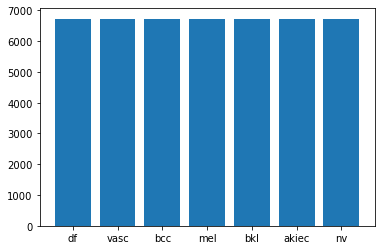

In [6]:
#check result

ds2= skinMNIST(df, tf)
desc= ds2.description()
print(desc)
desc= dict(desc)
plt.bar(desc.keys(), desc.values())
#df.to_csv(main_dir+'modifiedDataframe.csv')

# CNN 

#### split data to training & testing sets

In [7]:
# 80% Train 20% Test Spilt

train_size = int(0.8 * len(ds2))
test_size = len(ds2) - train_size

#randomaly devide data
trainset, testset= torch.utils.data.random_split(ds2, [train_size, test_size])
print(len(trainset), len(testset))

37596 9400


#### ResNet18

ResNet18 is a convolutional neural network architecture that has 18 layers, which was introduced by Microsoft Research.
One of the main reasons to use ResNet18 is that it has a relatively small size compared to other deep learning models while still achieving high accuracy.
Its high accuracy, small size, and availability in popular deep learning frameworks like PyTorch and TensorFlow make it a popular choice for many computer vision applications.

In [8]:
from torchvision import models
import torch.nn as nn

#net object is an instance of the ResNet class
net = models.resnet18(pretrained=True)

#after running 18 layers we will replace the fully connected layer which is the last step with an additional sequence of layers
#it includes:
#2 linear layers / one activation function relu / one dropout layer / one activation function softmax
net.fc = nn.Sequential(
                      #add a linear layer with input size 512 column by matrix and output image of size 256 columns
                      #which mean after applying the function  Y = X * Wt + b(bias) we will get a matrix with 256 column 
                      nn.Linear(512, 256), 
    
                      #apply ReLu activation function (render negative values to 0)
                      nn.ReLU(), 
    
                      #The nn.Dropout(p) layer is added to the neural network to prevent overfitting.
                      #Overfitting occurs when the model starts to memorize the training data instead of learning
                      #A value of 0.4 means that 40% of the input neurons will be randomly set to zero during training. 
                      nn.Dropout(0.4),
                      nn.Linear(256, 7),   
                      #apply the log Softmax  activation function 
                      nn.LogSoftmax(dim=1)
                      )
#moves the model to the GPU for faster training and evaluation
net

D:\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Result explanation

This architecture consists of multiple layers or blocks, with each block containing:
    - one or more convolutional layers
    - batch normalization layers
    - ReLU activation functions.

This ResNet architecture has four main components: 

    - the input convolutional layer (conv1):
        - takes 3-channel input image (RVB)
        - applies a 7x7 convolution (kernal) with a stride of 2 and a padding of 3 
        - followed by batch normalization and ReLU activation function
        - The max-pooling layer then downsamples the output by a factor of 2,it devide the feature map's width and hight two 2
        
    - the first layer of convolutional blocks (layer1):
        - contains two blocks, each of which applies two 3x3 convolutions 
        - batch normalization and ReLU activation
    - the second layer of convolutional blocks (layer2)
        - contains two blocks, each of which applies two 3x3 convolutions 
        - batch normalization and ReLU activation
    - the third layer of convolutional blocks (layer3).
        - contains two blocks, each of which applies two 3x3 convolutions 
        - batch normalization and ReLU activation
    - the fourth layer of convolutional blocks (layer4).
        - contains two blocks, each of which applies two 3x3 convolutions 
        - batch normalization and ReLU activation

In [9]:
#after defining the model wi will train it with training data

#train_loader and test_loader that will be used to load the training and testing data respectively.
#batch_size parameter is set to 32, it meaning that the DataLoader will load 32 samples at a time during training.
train_loader = DataLoader(trainset, batch_size= 32, shuffle= True)
test_loader = DataLoader(testset, batch_size= 32, shuffle= True)

#load data and it label from training set with the training loader (create iterator object thanks to iterfunction)
data, label= next(iter(train_loader))
print('original images :',data)

#pass the trained data to model
op= net(data)

#print the output of the first 32 sample to train
print('trained images result :',op)
print(np.shape(op))

original images : tensor([[[[ 1.8893,  1.8893,  1.8893,  ...,  1.8550,  1.8550,  1.8550],
          [ 1.8893,  1.8893,  1.8893,  ...,  1.8379,  1.8379,  1.8379],
          [ 1.8893,  1.8893,  1.8893,  ...,  1.8208,  1.8208,  1.8208],
          ...,
          [ 1.9578,  1.9578,  1.9578,  ...,  1.9578,  1.9578,  1.9578],
          [ 1.9920,  1.9920,  1.9920,  ...,  2.0434,  2.0434,  2.0605],
          [ 1.9920,  1.9920,  1.9920,  ...,  2.0434,  2.0434,  2.0605]],

         [[ 1.0805,  1.0805,  1.0805,  ...,  0.9930,  0.9930,  0.9930],
          [ 1.0805,  1.0805,  1.0805,  ...,  1.0105,  1.0105,  1.0105],
          [ 1.0805,  1.0805,  1.0805,  ...,  1.0455,  1.0455,  1.0455],
          ...,
          [ 0.9580,  0.9580,  0.9580,  ...,  1.1506,  1.1506,  1.1506],
          [ 1.0105,  1.0105,  1.0105,  ...,  1.0805,  1.0805,  1.0980],
          [ 1.0105,  1.0105,  1.0105,  ...,  1.0805,  1.0805,  1.0980]],

         [[ 1.4897,  1.4897,  1.4897,  ...,  1.5245,  1.5245,  1.5245],
          [ 

#### Loss Functions:

In machine learning and deep learnin, a loss function is used in classification problems to measure the difference between the predicted probabilities of the model and the true probabilities of the labels.

In simple terms, it calculates the difference between the predicted probability distribution and the true probability distribution.

There are many commun formular such as:

- Mean Squared Error (MSE) Loss: MSE = (1/n) * Σ(yi - ŷi)²
    This loss function is used for "regression problems" and calculates the average squared difference between the predicted and
    true values.
    
- Binary Cross-Entropy Loss: Loss = (1/N) * Σ[-y*log(ŷ) - (1-y)*log(1-ŷ)]
    This loss function is used for "binary classification problems" and calculates the cross-entropy between the predicted and
    true labels.

- Categorical Cross-Entropy Loss: Loss = (1/N) * Σ[Σ(yij * log(ŷij))]
    This loss function is used for "multi-class classification" problems and calculates the cross-entropy between the predicted
    and true labels.

- Hinge Loss: 
    This loss function is commonly used for support vector machines (SVMs) and is used to maximize the margin between classes.

- KL Divergence Loss: 
    This loss function is used for measuring the difference between two probability distributions.

- Triplet Loss: 
    This loss function is used for face recognition and is used to minimize the distance between anchor and positive samples and
    maximize the distance between anchor and negative samples.

- Custom Loss Functions: 
    In addition to these standard loss functions, custom loss functions can also be defined to suit the specific requirements of
    a given problem.

The formular that we will be using is "Cross-Entropy Loss function" H(p,q) = -Σi p(i)log(q(i))where:

- p is the true probability distribution
- q is the predicted probability distribution
- The log function is used to penalize incorrect predictions more than correct predictions
- The cross-entropy loss is minimized by adjusting the weights and biases of the model during training to improve the accuracy of predictions

#### Optimization Algorithms:

Optimization algorithm are used in deep learning for updating the weights and biases based on the gradients of the loss function with respect to the parameters of a neural network during training.

Some famous algorithms:
- Stochastic Gradient Descent (SGD): 
    It is a popular optimization algorithm used to minimize the loss function in neural networks. 
    It updates the weights in the direction of the negative gradient of the loss function.

- Adam (Adaptive Moment Estimation): 
    It is an optimization algorithm that computes adaptive learning rates for each parameter. 
    It is based on the combination of RMSprop and momentum methods.

- Adagrad (Adaptive Gradient): 
    It is an optimization algorithm that adapts the learning rate to the parameters, performing larger updates for infrequent
    and smaller updates for frequent parameters.

- Adadelta: 
    It is a variant of Adagrad that seeks to reduce the aggressive, monotonically decreasing learning rate.

- RMSprop (Root Mean Square Propagation): 
    It is an optimization algorithm that divides the learning rate by an exponentially decaying average of squared gradients.

- Nadam (Nesterov-accelerated Adaptive Moment Estimation): 
    It is an extension of Adam that uses Nesterov momentum in addition to traditional momentum.

- LBFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno): 
    It is a quasi-Newton optimization algorithm that approximates the Hessian matrix in order to converge faster than first
    order methods like SGD.
    
In our case we will adapt the Adam optimizer:
    mt=β1​-mt−1+(1−β1)gt
    vt=β2​vt−1+(1−β2)gt2
    
    mt*=mt/(1-β1^t)
    vt*=vt/(1−β2t^t)
    
    θt=θt−1−α​(mt*/square(vt*)+ϵ)

#### Over Fitting

Overfitting occurs when a model has been trained too well on a specific training dataset, to the point where it memorizes the training data rather than learning the underlying patterns in the data that would enable it to generalize to new, unseen data. 

#### Preventing Over Fitting

One way to prevent overfitting is to add a regularization term to the loss function during training. L2 regularization, also known as weight decay, adds a penalty term to the loss function proportional to the squared magnitude of the model weights. This penalty encourages the model to learn smaller weights and helps to prevent overfitting. By adding L2 loss to our optimization function, we encourage the model to learn simpler representations of the data and prevent it from overfitting to the training data.

# Start Training

In [10]:
from torch.utils.data import DataLoader
import torch.optim as optim

#set up the loss function to use during training
criterion= nn.CrossEntropyLoss()

#a list to store the validation loss values
val_losses= []

#this function is used to to evaluate the performance of the model
def validation():
    
    #initialise validation loss value
    vloss= 0.0
    
    print('validating..')
    #disable gradient calculation during validation to save memory and speed up the process
    with torch.no_grad():
        #sets the model to evaluation mode,to disables certain layers (such as dropout) that are only used during training
        net.eval()
        
        #to keep track of the number of correctly classified examples during validation
        #total_count : total number of testing images 
        #true_count : correctly predicted ones
        total_count, true_count, i= 0, 0, 0
        
        for test_data, test_label in (test_loader):
            
            #incriment batch counter( training data subset)
            i+=1
            
            #feed the model with test data
            output= net(test_data) 
            
            #compare test_label with the predicted output and compare them and adds the validation loss 
            #vloss+= criterion(output, test_label).float()
            vloss += criterion(output, test_label.float())
            
            #Tcalculates the average validation loss over all batches(training subsets) processed so far
            avg_val_loss= vloss/i
            
            #loop iterates over each prediction and corresponding label in the current batch
            for op, test in zip(output, test_label):
                
                #total count of example
                total_count+= 1
                
                #checks if the predicted label is equal to the true label
                predicted = torch.argmax(op)
                #print("predicted label index: ",predicted," true label index: ",test," for epoch btach number: ",i)
                #if torch.all(predicted == test):
                if (test[predicted] == 1):
                    true_count+= 1
                    
        #calculate the percentage of examples that were correctly classified during validation     
        correct= (true_count * 100)/ total_count
        
        #appends the average validation loss to the list of validation losses for this try
        val_losses.append(avg_val_loss)
        return avg_val_loss, correct




# Training starts here  

#applying adam optimisation algorithm : H(p,q) = -Σi p(i)log(q(i))
#learning rate = 0.0001 & weight decay = 1e-5
optimizer = optim.Adam(net.parameters(), lr= 0.0001, weight_decay=1e-5)

#maximum number of epochs to wait before stopping early if the validation loss does not improve
#In machine learning, an epoch is one complete iteration through the entire dataset during the training of a model
#The model makes predictions on each example in the batch, and the loss is calculated based on the difference between the predicted and actual values
#The optimizer then updates the model weights based on the loss, and the process is repeated for the next batch until all batches in the dataset have been processed
patience = 16

#initializes an empty list to store the training loss values
train_losses= []

#itializes an empty list to store the validation loss values
val_losses= []

patience= 3

    
#the network is trained for 20 epochs
for epoch in range(1, 20):
    
    print('training..')
    
    #sets the network in training mode.
    net.train()
    
    totalloss= 0
    #batch counter
    i= 0
    
    for train_data, train_label in tqdm(train_loader, desc='Training epoch {}'.format(epoch)):
        #resets the gradients of all network parameters
        optimizer.zero_grad()
        
        #feed the model with training data
        output= net(train_data)
        
        #calculates the training loss of the network for the current batch using the specified loss criterion
        loss= criterion(output, train_label.float())
        
        totalloss+= loss
        i+=1
        
        #average training loss per batch
        avgloss= totalloss/i
        
        #gradient-based optimization (back propagation)
        #During forward propagation, the network takes input data, applies its weights and biases, and generates predictions
        #The loss function compares the predicted output to the actual output and produces a value that measures the difference between the two
        #Backpropagation is a way of computing the gradients of the loss with respect to each weight and bias in the network
        
        #computes the gradients of the loss with respect to the network parameters using back propagation
        loss.backward()
        
        #updates the network parameters based on the computed gradients and the optimization algorithm
        optimizer.step()
        
    # appends the average training loss of the epoch to a list.
    train_losses.append(avgloss) 
    
    #evaluate current epoch results
    valloss, acc= validation()
    
    print('training loss in epoch {} is {}, validation loss is {} correctly classified= {} %'.format(epoch, avgloss, valloss, acc))
    
    try:
        #implement early stopping:
        #The validation loss is monitored to check if it has decreased in the current epoch compared to the previous epoch.
        #If the validation loss has not decreased for patience number of epochs, training is stopped early
        if(val_losses[-1] >= val_losses[-2]):
            print('Early stopping... saving checkpoint..')
            
            #if stopped, it will make a checkpoint of the current model
            torch.save(net.state_dict(), 'checkpoint_{}_{}.pt'.format(epoch, acc))
            
            patience-=1
            #checks if the patience counter has reached zero, indicating that training should be stopped early.
            if patience == 0:
                break
    except:
        pass


training..


<ipython-input-10-97456cb86984>:98: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for train_data, train_label in tqdm(train_loader, desc='Training epoch {}'.format(epoch)):


Training epoch 1:   0%|          | 0/1175 [00:00<?, ?it/s]

validating..
training loss in epoch 1 is 0.4395943582057953, validation loss is 0.3042776882648468 correctly classified= 89.25531914893617 %
training..


Training epoch 2:   0%|          | 0/1175 [00:00<?, ?it/s]

validating..
training loss in epoch 2 is 0.14935418963432312, validation loss is 0.13868479430675507 correctly classified= 95.38297872340425 %
training..


Training epoch 3:   0%|          | 0/1175 [00:00<?, ?it/s]

validating..
training loss in epoch 3 is 0.09124748408794403, validation loss is 0.1052161380648613 correctly classified= 96.2127659574468 %
training..


Training epoch 4:   0%|          | 0/1175 [00:00<?, ?it/s]

validating..
training loss in epoch 4 is 0.07267770916223526, validation loss is 0.09725327044725418 correctly classified= 96.74468085106383 %
training..


Training epoch 5:   0%|          | 0/1175 [00:00<?, ?it/s]

validating..
training loss in epoch 5 is 0.05361168831586838, validation loss is 0.061108674854040146 correctly classified= 98.05319148936171 %
training..


Training epoch 6:   0%|          | 0/1175 [00:00<?, ?it/s]

validating..
training loss in epoch 6 is 0.042379606515169144, validation loss is 0.10474040359258652 correctly classified= 96.65957446808511 %
Early stopping... saving checkpoint..
training..


Training epoch 7:   0%|          | 0/1175 [00:00<?, ?it/s]

validating..
training loss in epoch 7 is 0.044219356030225754, validation loss is 0.12114069610834122 correctly classified= 96.59574468085107 %
Early stopping... saving checkpoint..
training..


Training epoch 8:   0%|          | 0/1175 [00:00<?, ?it/s]

validating..
training loss in epoch 8 is 0.03359290212392807, validation loss is 0.14615999162197113 correctly classified= 95.54255319148936 %
Early stopping... saving checkpoint..


### [CHECKPOINT] Create a saved object of the current model to use it later

In [11]:
import torch.optim as optim

optim = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
'''
print("Accessing the model state_dict")
for values in net.state_dict():
    print(values, "\t", net.state_dict()[values].size())
    
print("Accessing the optimizers state_dict")
for elements in optim.state_dict():
    print(elements, "\t", optim.state_dict()[elements])
'''   
# Save the model's state dictionary
torch.save(net.state_dict(), "E:/Projects/PFA/Data sets/data/checkpoint_11_97.95744680851064.pt")

# Load the model's state dictionary from the saved file
#loaded_state_dict = torch.load("E:/Projects/PFA/Data sets/data/checkpoint_11_97.95744680851064.pt")


##### Test Results

In [12]:
from colorama import Fore, Style
from torchviz import make_dot
#temporarily disables gradient calculation, to save memory since gradients are not needed for evaluation.
with torch.no_grad():
    
    # This sets the network net to evaluation mode (some layers will behave differently)
    net.eval()
    #retrieve a batch of data and labels from the test_loader
    data, label= next(iter(test_loader))
    
    for i in range (1,20):
        #contains the data to test on through model (net) 
        op= net(data)[0]

        print("predicted values(label): ",op)

        print("index of highest predicted label: ",torch.argmax(op))

        print("the real label according to testing data: ",label[0])

        array = label[0].numpy()

        if (torch.argmax(op) == np.where(array == 1)[0][0]):
            print(Fore.GREEN+"############# TEST number ",i," Results are positif! ################"+Style.RESET_ALL)
        else:
            print(Fore.RED +"############# TEST number ",i," Results are negative ################"+Style.RESET_ALL)
        
        # Create a graph of the model
        graph = make_dot(output, params=dict(net.named_parameters()))
        
        # Save the graph as a PDF file
        graph.render("E:/Projects/PFA/Data sets/data/resnet18_graph")

predicted values(label):  tensor([-1.6689e-06, -1.3616e+01, -1.4545e+01, -1.8494e+01, -1.8048e+01,
        -1.9879e+01, -1.8637e+01])
index of highest predicted label:  tensor(0)
the real label according to testing data:  tensor([1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
############# TEST number  1  Results are positif! ################
predicted values(label):  tensor([-1.6689e-06, -1.3616e+01, -1.4545e+01, -1.8494e+01, -1.8048e+01,
        -1.9879e+01, -1.8637e+01])
index of highest predicted label:  tensor(0)
the real label according to testing data:  tensor([1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
############# TEST number  2  Results are positif! ################
predicted values(label):  tensor([-1.6689e-06, -1.3616e+01, -1.4545e+01, -1.8494e+01, -1.8048e+01,
        -1.9879e+01, -1.8637e+01])
index of highest predicted label:  tensor(0)
the real label according to testing data:  tensor([1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
############# TEST number  3  Results are positif! 

###### test with a new image for verification

In [13]:
from random import randint

for i in range (1,10):
    random_variable= randint(1, 10000)
    imageid= df.iloc[random_variable].image_id
    cancertype= df.iloc[random_variable].dx
    try:
        image= Image.open(('E:/Projects/PFA/Data sets/data/ham10000_images_part_2/' + imageid + '.jpg'))
    except:
        image= Image.open(('E:/Projects/PFA/Data sets/data/ham10000_images_part_1/' + imageid + '.jpg'))

    # convert jpeg image into 3 dimentional tensor
    trans =transforms.ToTensor()
    # convert image into 4 dimentional tensor required to feed into the network
    image= trans(image).unsqueeze(0)
    inversedict= dict(zip(range(7), ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']))
    with torch.no_grad():
        net.eval().cpu()
        op= net(image)
        op= op.argmax().item()
        print('image_name:', imageid)
        if(cancertype == inversedict[op]):
            print(Fore.GREEN+'real:', cancertype)
            print(Fore.GREEN+'predicted:', inversedict[op])
        else:
            print(Fore.RED+'real:', cancertype)
            print(Fore.RED+'predicted:', inversedict[op])

image_name: ISIC_0030341
real: akiec
predicted: nv
image_name: ISIC_0025182
real: akiec
predicted: nv
image_name: ISIC_0025252
real: nv
predicted: nv
image_name: ISIC_0025975
real: bcc
predicted: nv
image_name: ISIC_0025759
real: nv
predicted: nv
image_name: ISIC_0025377
real: nv
predicted: nv
image_name: ISIC_0027425
real: bcc
predicted: nv
image_name: ISIC_0024801
real: nv
predicted: nv
image_name: ISIC_0029647
real: bcc
predicted: bkl


new_net is set
predicted: nv


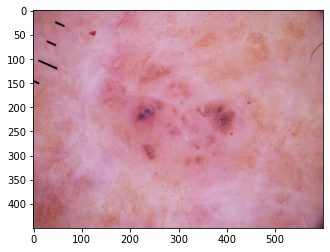

In [14]:
from torchvision import models
import torch.nn as nn
from PIL import Image
from torchvision.transforms import transforms
import torch
import matplotlib.pyplot as plt


# Create a new instance of your model
new_net = models.resnet18(pretrained=True)
new_net.fc = nn.Sequential(
                      nn.Linear(512, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 7),                   
                      nn.LogSoftmax(dim=1)
                      )
new_net.load_state_dict(torch.load("E:/Projects/PFA/Data sets/data/checkpoint_11_97.95744680851064.pt"))

if new_net is not None:
    print("new_net is set")
else:
    print("new_net is not set")
#######################################

#test with new net
IMAGEPATH= 'E:/Projects/PFA/Data sets/data/HAM10000_images_part_1/ISIC_0024472.jpg'
checkpoint = torch.load('E:/Projects/PFA/Data sets/data/checkpoint_11_97.95744680851064.pt')
new_net.load_state_dict(checkpoint)
image= Image.open(IMAGEPATH)
trans =transforms.ToTensor()
image_tensor= trans(image).unsqueeze(0)
inversedict= dict(zip(range(7), ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']))
with torch.no_grad():
    new_net.eval().cpu()
    op= net(image_tensor)
    op= op.argmax().item()
    plt.imshow(image)
    print('predicted:', inversedict[op])

In [15]:
import torch
import torchvision.models as models
from torchsummary import summary


# Print the summary of the model
summary(net, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Visualisation

In [16]:
#plotting the confusion matrix
def get_all_preds(model):
    # an instance of the dataset
    ds= skinMNIST(df, tf)
    all_batches= DataLoader(ds, batch_size= 32, shuffle= False)
    cfmat= []
    with torch.no_grad():
        model.eval()
        for batches, labels in tqdm(all_batches):
            op= model(batches)
            op= op.argmax(dim=1)
            '''
            
            result = []
            for vector in label:
                for value in vector:
                    if value == 1:
                        result.append(vector.tolist().index(value))
                        break
            label_vector = torch.tensor(result)
            print(result,op,)
            
            #op = op.unsqueeze(1).expand(-1, labels.size(1))  # Reshape op to match the size of labels
            stack= torch.stack((op, label_vector), dim=1)
            '''
            labels= labels.argmax(dim=1)
            print(op,labels)
            stack= torch.stack((op, labels), dim=1)
            cfmat+= stack.tolist()
          
    return cfmat

cf= get_all_preds(net)

<ipython-input-16-d38ea741a563>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batches, labels in tqdm(all_batches):


  0%|          | 0/1469 [00:00<?, ?it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2]) tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2,
        2, 2, 2, 2, 2, 2, 2, 3]) tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([5, 2, 2, 2, 2, 5, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2]) tensor([5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2]) tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

In [17]:
import seaborn as sns

print(np.shape(cf))
cfmat= np.zeros((7,7), dtype= int)
for p in cf:
    tl, pl = p
    cfmat[tl, pl] = cfmat[tl, pl] + 1
print('confusion matrix:\n',cfmat)

(46996, 2)
confusion matrix:
 [[6690    4   20    0  203    2    0]
 [   7 6686    2    1   18    2    0]
 [   9   21 6649    0  465   28    0]
 [   0    0    4 6726   31    1    0]
 [   0    1   10    0 5502    6    1]
 [   1    3   24    0  492 6664    0]
 [   0    0    0    0    0    2 6721]]


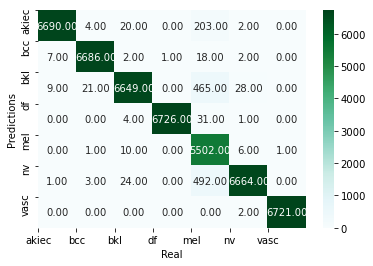

In [18]:
res = sns.heatmap(cfmat, annot=True, fmt='.2f',cmap=plt.cm.BuGn)
plt.ylabel('Predictions')
plt.xlabel('Real')
plt.xticks(range(7), [inversedict[i] for i in range(7)])
plt.yticks(range(7), [inversedict[i] for i in range(7)])
plt.show()